In [1]:
import torch
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from src.scripts.models.U3plus import unet3plus
from src.scripts.models.U2Net import U2Net 
from src.scripts.DataLoaders import HeartLoader, get_image_filepaths, ImgForPlot, LeftCamusDataset
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader

In [5]:
img_size = (256, 256)

# model_name = 'Unet3plus_1'  # 'u2net-cardio_segmentation'    Unet3plus_1
# model_saved_dir = "results/Unet3+"
model_name = 'u2net-left_best'
model_saved_dir = 'models/U2Net'

# loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"  # _best

# with open(loss_path, 'rb') as f:
#   losses = pickle.load(f)

# model = unet3plus(num_classes=2).cuda()
model = U2Net(num_classes=2).cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [6]:
# Write transform for image
data_transform = transforms.Compose([
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    transforms.Resize(size=img_size),
])

In [7]:
format = '.png'

# train_path = "data/train/train"
test_path = "data/train/echoLA/testing"

img_test_paths = get_image_filepaths(os.path.join(test_path, "images"), img_format='.jpg')
msk_test_paths = get_image_filepaths(os.path.join(test_path, "masks"), format)

test_dataset = LeftCamusDataset(img_test_paths, msk_test_paths, transforms=data_transform)

len(msk_test_paths)

2235

In [8]:
os.path.exists(msk_test_paths[0])

True

In [9]:
def prepare_input(img, image_size=(512, 512)):
    # 
    if img.shape[:2] != image_size:
        img = cv2.resize(img, image_size)

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [10]:
imgage = cv2.cvtColor(cv2.imread(img_test_paths[-1]), cv2.COLOR_BGR2RGB)
new_img = prepare_input(imgage, img_size)
print(new_img.shape)

msk = cv2.imread(msk_test_paths[-1], 0)
msk = np.where(msk > 0, 255, 0)

pred = model(new_img)[-1]
pred = prepare_output(pred)
pred.shape

torch.Size([1, 3, 256, 256])


(256, 256, 2)

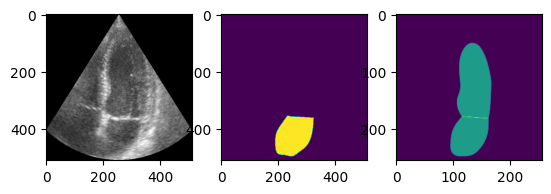

In [11]:
plt.subplot(131)
plt.imshow(imgage)
plt.subplot(132)
plt.imshow(msk)
plt.subplot(133)
plt.imshow(pred.sum(axis=-1))

(944, 1392, 3)


[mjpeg @ 0x59eed1a5fac0] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed5625ac0] unable to decode APP fields: Invalid data found when processing input


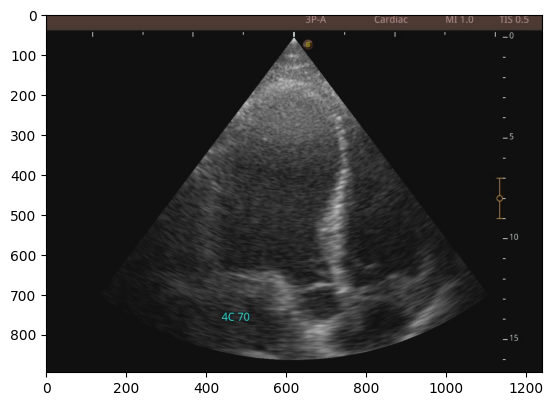

In [12]:
video_name = 'data/temporary/20240708_101231366.avi'

cap = cv2.VideoCapture(video_name)
# cap.set(2, frame_no);
ret, frame = cap.read()
print(frame.shape)
plt.imshow(frame[50:, 150:, :])

In [13]:
new_img = prepare_input(frame[50:, 150:, :], img_size)
print(new_img.shape)
pred = model(new_img)[-1]
pred = prepare_output(pred)
pred.shape

torch.Size([1, 3, 256, 256])


(256, 256, 2)

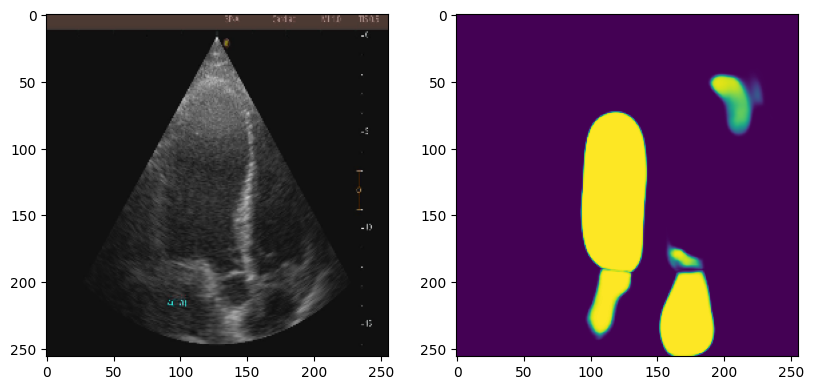

In [14]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.imshow(cv2.resize(frame[50:, 150:, :], img_size))
plt.subplot(132)
plt.imshow(pred.sum(axis=-1))

## Find the worst predictions in test

In [15]:
from src.scripts.losses import DiceBCELoss

In [18]:
device = 'cuda:0'

# Test dataset
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2)
# Loss func
DBCE = DiceBCELoss()

losses = {}
test_loss = 0.
model.eval()
with torch.no_grad():
  for i, (input, target) in tqdm(enumerate(test_dataset), total=len(test_dataset)):
    # print(input.shape, target.shape)
    input, target = input.unsqueeze(0).to(device), target.unsqueeze(0).to(device)
    out = model(input)[-1]
    curr_loss = DBCE(out, target).item() / len(test_dataloader)
    test_loss += curr_loss

    losses[f'{i}'] = curr_loss

print(test_loss)

100%|██████████| 2235/2235 [00:47<00:00, 47.33it/s]

0.07848934171683834


In [19]:
import pandas as pd

df = pd.Series(losses.values(), index=losses.keys())
df.sort_values().index

Index(['182', '150', '2022', '178', '2004', '50', '2095', '2005', '2003',
       '2093',
       ...
       '1261', '2149', '2224', '2148', '2221', '2223', '2147', '61', '2222',
       '126'],
      dtype='object', length=2235)

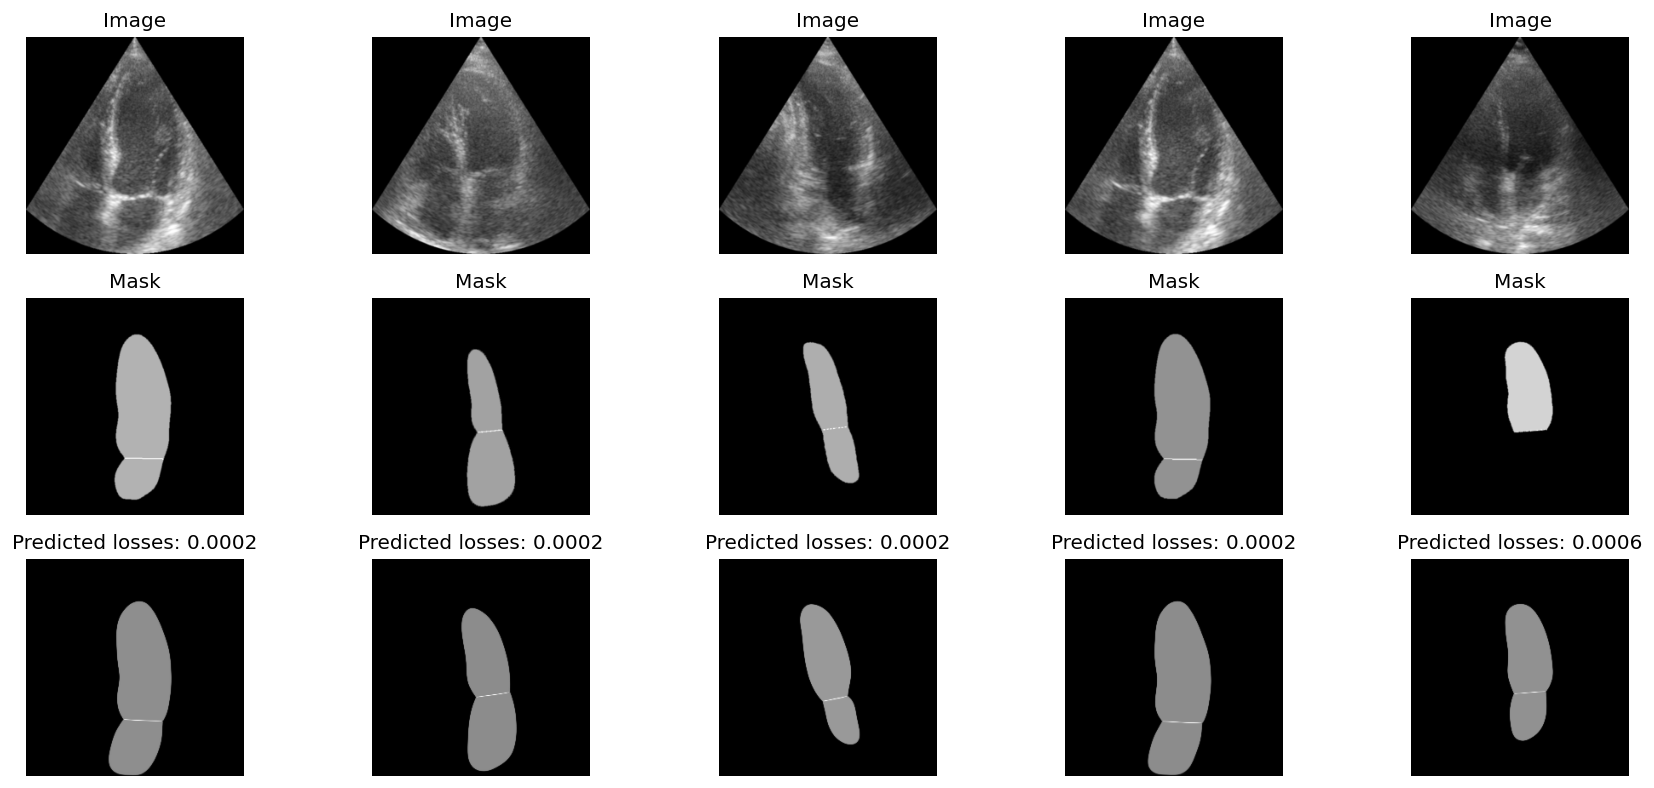

In [20]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(18, 8), dpi=120)

for j, i in enumerate(df.sort_values().index[-5:]):
    i = int(i)

    input, target = test_dataset[i]
    input, target = input.cpu().detach().numpy(), target.cpu().detach().numpy()
    
    ax[0, j].set_title('Image')
    ax[0, j].set_axis_off()
    ax[0, j].imshow(np.transpose(input, (1, 2, 0)))

    ax[1, j].set_title('Mask')
    ax[1, j].set_axis_off()
    ax[1, j].imshow(np.transpose(target, (1, 2, 0)).sum(axis=-1), 'gray')

    input = torch.from_numpy(np.expand_dims(input, 0))
    pred = model(input.to(device))[-1]
    pred = prepare_output(pred)
    ax[2, j].set_title(f'Predicted losses: {round(losses[f"{i}"], 4)}')
    ax[2, j].set_axis_off()
    ax[2, j].imshow(pred.sum(axis=-1), 'gray')

plt.show()

IndexError: list index out of range

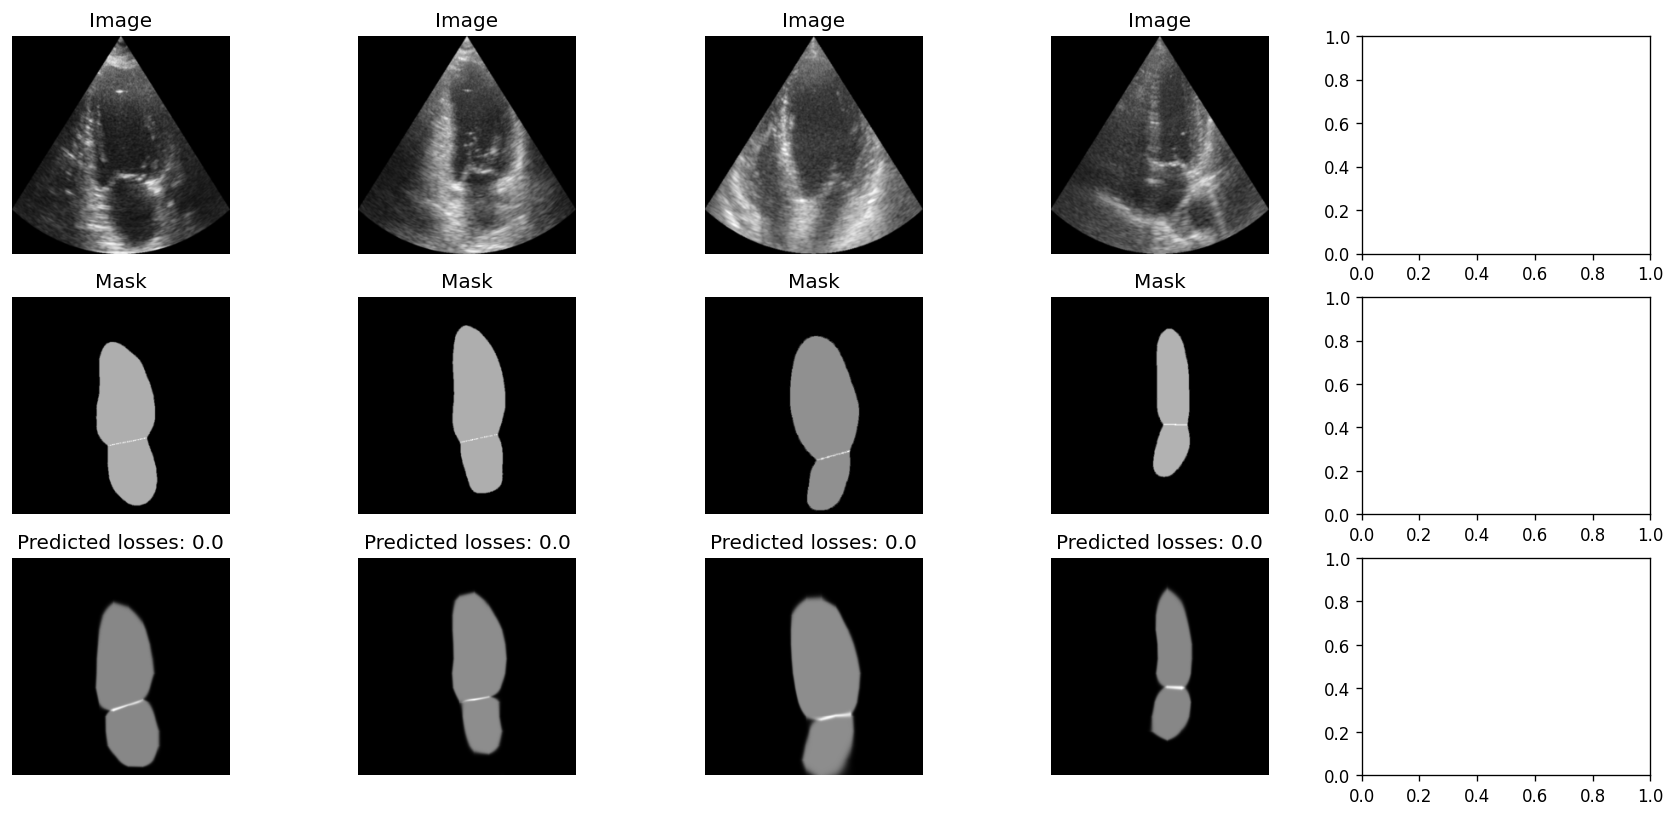

In [19]:
# fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(18, 8), dpi=120)

# for j, i in enumerate([0, 100, 500, 1000, 4000]):

#     input, target = test_dataset[i]
#     input, target = input.cpu().detach().numpy(), target.cpu().detach().numpy()
    
#     ax[0, j].set_title('Image')
#     ax[0, j].set_axis_off()
#     ax[0, j].imshow(np.transpose(input, (1, 2, 0)))
#     ax[1, j].set_title('Mask')
#     ax[1, j].set_axis_off()
#     ax[1, j].imshow(np.transpose(target, (1, 2, 0)).sum(axis=-1), 'gray')

#     input = torch.from_numpy(np.expand_dims(input, 0))
#     pred = model(input.to(device))[-1]
#     pred = prepare_output(pred)
#     ax[2, j].set_title(f'Predicted losses: {round(losses[f"{i}"], 4)}')
#     ax[2, j].set_axis_off()
#     ax[2, j].imshow(pred.sum(axis=-1), 'gray')

# plt.show()

## Make gif with predictions of .avi video

In [21]:
import imageio

In [22]:
real_path = 'data/real/20240708_095014_CARD'

ch4_names = [
    '20240708_101149959.avi',
    '20240708_101216285.avi',
    '20240708_101231366.avi',
    '20240708_101247312.avi',
    '20240708_101300234.avi',
    '20240708_101337896.avi',
    '20240708_101356037.avi',
    '20240708_101410225.avi',
    '20240708_101449930.avi',
    '20240708_101527783.avi', 
]
# ch2_names = []

ch4_paths = [ os.path.join(real_path, name) for name in ch4_names]
# ch2_paths = [ ]
ch4_paths[:5]

['data/real/20240708_095014_CARD/20240708_101149959.avi',
 'data/real/20240708_095014_CARD/20240708_101216285.avi',
 'data/real/20240708_095014_CARD/20240708_101231366.avi',
 'data/real/20240708_095014_CARD/20240708_101247312.avi',
 'data/real/20240708_095014_CARD/20240708_101300234.avi']

(944, 1392, 3)

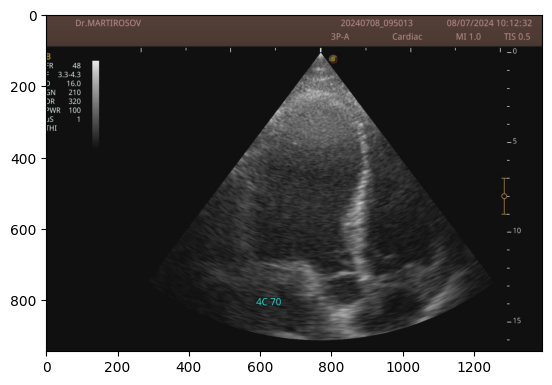

In [23]:
plt.imshow(frame)
frame.shape

In [25]:
fps = 3

for path in ch4_paths:
    frames = []
    cap = cv2.VideoCapture(path)

    while True:
        ret, frame = cap.read()
        if ret:
            input_img = frame[100:, 250:-80, :]
            image = cv2.resize(input_img, (128, 128), cv2.INTER_LINEAR)
            # Save original image to output frame
            # new_frame[:128, :, :] = im
            inputs = prepare_input(input_img, image_size=img_size)
            pred = model(inputs)[-1]
            pred = prepare_output(pred)
            pred = cv2.cvtColor(pred.sum(axis=-1), cv2.COLOR_GRAY2RGB)
            
            pred = cv2.resize(pred, (128, 128), cv2.INTER_LINEAR)
            pred = (pred * 255).astype('uint8')
            # 
            new_frame = np.concat([image, pred], axis=1)
            # plt.imshow(new_frame)
            # break
            frames.append(new_frame)  
        else:
            break

        
    cap.release()

    name = os.path.basename(path)
    name = name.split(".")[0]
    name_model = model_saved_dir.split("/")[-1]
    path2save = f'results/{name_model}/gifs/{name}.gif'
    imageio.mimsave(path2save, frames, format='GIF', fps=fps)

    # break

[mjpeg @ 0x59eee1dc4900] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x59eed4648280] unable to decode APP fiel

In [26]:
pred.shape, pred.max(), np.unique(pred), inputs.shape, inputs.max()

((128, 128, 3),
 np.uint8(205),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  20,  21,  22,  23,  24,  25,  26,
         28,  29,  30,  31,  32,  34,  36,  37,  38,  39,  40,  41,  45,
         46,  47,  49,  50,  51,  52,  53,  55,  56,  57,  58,  60,  63,
         64,  66,  67,  68,  69,  70,  71,  73,  74,  75,  76,  77,  78,
         79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  91,  92,  94,
         95,  97,  98,  99, 100, 101, 102, 103, 105, 107, 110, 112, 114,
        116, 118, 121, 122, 124, 126, 127, 135, 138, 139, 141, 142, 144,
        147, 159, 165, 173, 176, 196, 205], dtype=uint8),
 torch.Size([1, 3, 256, 256]),
 tensor(0.9412, device='cuda:0'))

In [27]:
pr = model(inputs)[-1]
pr.shape

torch.Size([1, 2, 256, 256])

In [28]:
pr.max()

tensor(1.5351, device='cuda:0', grad_fn=<MaxBackward1>)

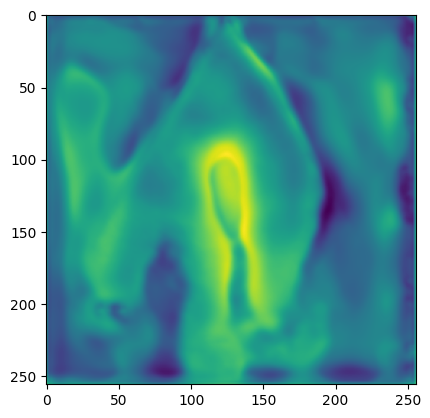

In [29]:
plt.imshow(np.transpose(pr[0].cpu().detach().numpy(), (1, 2, 0)).sum(-1))

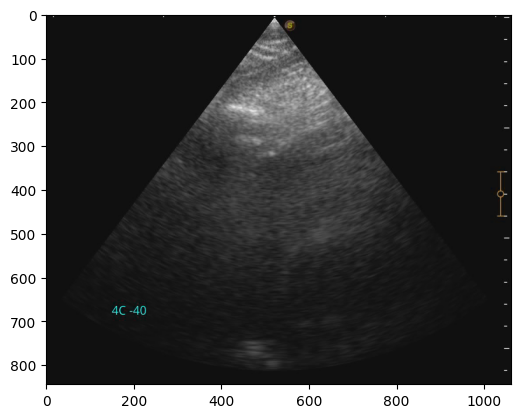

In [30]:
plt.imshow(input_img)

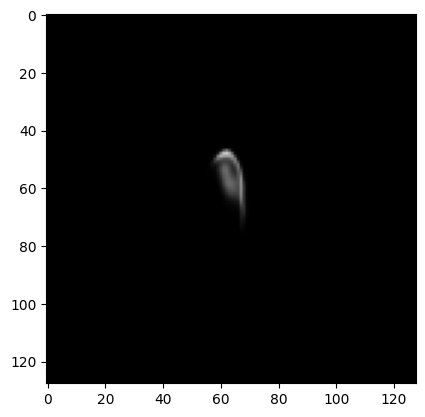

In [31]:
plt.imshow(pred)

In [28]:
# import imageio

 

# video_name = 'data/temporary/20240708_101449930.avi'
# gif = cv2.VideoCapture(video_name)
# fps = gif.get(cv2.CAP_PROP_FPS)
# frames = []
    
# while True:
#     ret, frame = gif.read()
#     if ret:
#         # new_frame = np.zeros((256, 128))   # Original_img - Predicted mask

#         im = frame[50:, 150:, :]
#         image = cv2.resize(im, (128, 128), cv2.INTER_LINEAR)
#         # Save original image to output frame
#         # new_frame[:128, :, :] = im
#         inputs = prepare_input(im)
#         pred = model(inputs)[-1]
#         pred = prepare_output(pred)
#         pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
#         pred = (pred * 255).astype('uint8')
#         pred = cv2.resize(pred, (128, 128), cv2.INTER_LINEAR)
#         # 
#         new_frame = np.concat([image, pred], axis=1)
#         # break
#         frames.append(new_frame)    
#     else:
#         break
        

# imageio.mimsave('results/test_movie_3.gif', frames, format='GIF', fps=fps)